In [1]:
# dependency
import numpy as np
import pandas as pd
import copy
import math
import sys
import os
from activations import relu, leaky_relu, sigmoid, tanh, softmax, d_sigmoid, d_relu
from initializers import glorot_uniform, random_normal, random_uniform
from regularizers import l1_regularizer, l2_regularizer
from utility import trim_tail, multiply, subtract, get_nparams, one_hot_encoding, get_data
from metrics import MSE, CCE, ACC, PRECISION, RECALL, essential_metrics, wondering_penalty, close_gap_penalty
from pso import PSO
from ga import GA
from nn import Network
from layer import DenseLayer
from scalers import MinMaxScaler, StandardScaler

In [2]:
# reference
metrics_fn_dict = dict()
metrics_fn_dict['accuracy'] = ACC
metrics_fn_dict['categorical_crossentropy'] = CCE
metrics_fn_dict['mean_square_error'] = MSE
metrics_fn_dict['precision'] = PRECISION
metrics_fn_dict['recall'] = RECALL
metrics_fn_dict['essential_metrics'] = essential_metrics

In [3]:
# model
model = Network(5, lr = None)
model.add_layer(DenseLayer(1, 4, True, afn=sigmoid, dafn=None, rfn=None))
model.add_layer(DenseLayer(2, 3, True, afn=softmax, dafn=None, rfn=None))

In [4]:
pso = PSO(dict(m = 50,
    weight_constraint = [-3, 3], 
    velocity_constraint = [-0.1, 0.1],
    c1 = 2,
    c2 = 2,
    w = 1,
    w_decay = 1,
    scale_hyperparameter = False,
    regularizer = l1_regularizer,
    mask = True))

In [5]:
model.compile(loss_fn = 'categorical_crossentropy', optimizer = pso, \
    metrics = ['accuracy', 'mean_square_error', 'categorical_crossentropy'])

building layer 1 with 5
24
building layer 2 with 4
15


In [6]:
# data loading
DATA = os.path.join('c:\\Users\\tcumi\\github_repo\\neural-network\\', 'dataset')
GROUP = 4
COLUMNS = ['f1', 'f2', 'f3', 'f4', 'f5', 'label']
N_CLASS = 3
EPOCHS = 500
train_dir, test_dir = "..//dataset//training_data{}.txt".format(GROUP), "..//dataset//testing_data{}.txt".format(GROUP)
train, test = get_data(DATA, train_dir, COLUMNS), get_data(DATA, test_dir, COLUMNS)
# shuffle
train, test = train.sample(frac=1), test.sample(frac=1)
x_train, y_train = train.drop('label', axis=1), train['label']
x_test, y_test = test.drop('label', axis=1), test['label']

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 107 entries, 0 to 106
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   f1      107 non-null    float32
 1   f2      107 non-null    float32
 2   f3      107 non-null    float32
 3   f4      107 non-null    float32
 4   f5      107 non-null    float32
 5   label   107 non-null    float32
dtypes: float32(6)
memory usage: 2.6 KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 108 entries, 0 to 107
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   f1      108 non-null    float32
 1   f2      108 non-null    float32
 2   f3      108 non-null    float32
 3   f4      108 non-null    float32
 4   f5      108 non-null    float32
 5   label   108 non-null    float32
dtypes: float32(6)
memory usage: 2.7 KB
None


In [7]:
# data scaling and encoding
scaler = StandardScaler(['f1', 'f2', 'f3', 'f4', 'f5'])
scaler.fit(x_train)
x_train = scaler.transform(x_train)
x_test = scaler.transform(x_test)
y_train = one_hot_encoding(y_train, N_CLASS)
y_test = one_hot_encoding(y_test, N_CLASS)

In [8]:
# learning phase
breakpoint = 100
checkpoints = list()
history = list()
for century in range(0, EPOCHS, breakpoint):
    sub_history = model.fit(x_train, y_train, breakpoint, verbose = 0)
    score = model.evaluate(x_test, y_test, False, verbose = 0)
    print('Checkpoint {}, Accuracy: {}, Loss: {}'.format(century+breakpoint, score['accuracy'], score[model.loss_fn]))
    score['checkpoint'] = century + breakpoint
    checkpoints.append(score)
    history.extend(sub_history)

Checkpoint 100, Accuracy: 0.9382716049382716, Loss: 0.29194888362178095
Checkpoint 200, Accuracy: 0.9691358024691358, Loss: 0.23432272451895256
Checkpoint 300, Accuracy: 0.9753086419753086, Loss: 0.20894320805867514
Checkpoint 400, Accuracy: 0.9753086419753086, Loss: 0.22060581489845557
Checkpoint 500, Accuracy: 0.9814814814814815, Loss: 0.20754415017587166


In [9]:
import matplotlib.pyplot as plt

def draw_plot(x, y_list, x_label=None, y_label=None, legend=None, title=None):
    fig, ax = plt.subplots(figsize=(12,5))
    for xi, yi in zip(x, y_list):
        ax.plot(xi, yi)
    if x_label is not None and y_label is not None:
        ax.set(xlabel=x_label, ylabel=y_label, title='{} VS {}'.format(x_label, y_label))
    if legend is not None:
        ax.legend(legend)
    ax.grid()
    plt.show()

In [10]:
# recall phase
score = model.evaluate(x_test, y_test, False)
print(score)

[1. 0. 0.] <-> [0.48226982 0.08119343 0.4365367 ]
[0. 0. 1.] <-> [0.76582795 0.03613658 0.1980355 ]
[1. 0. 0.] <-> [0.8928499  0.07895244 0.02819764]
[0. 1. 0.] <-> [0.05980918 0.9282516  0.01193927]
[1. 0. 0.] <-> [0.929543   0.02547109 0.04498588]
[1. 0. 0.] <-> [0.90531033 0.03240668 0.06228304]
[0. 1. 0.] <-> [0.2742992  0.6991867  0.02651417]
[1. 0. 0.] <-> [0.9398753  0.03146214 0.02866257]
[1. 0. 0.] <-> [0.9024923  0.0562568  0.04125097]
[1. 0. 0.] <-> [0.8689569  0.09017511 0.04086798]
[0. 0. 1.] <-> [0.7144039  0.05599128 0.22960472]
[1. 0. 0.] <-> [0.9425436  0.0288359  0.02862041]
[0. 0. 1.] <-> [0.4775543  0.03589601 0.48654962]
[0. 0. 1.] <-> [0.08196297 0.0508897  0.8671473 ]
[1. 0. 0.] <-> [0.91775554 0.04044594 0.04179846]
[1. 0. 0.] <-> [0.70970404 0.25452507 0.03577096]
[1. 0. 0.] <-> [0.94090897 0.03606372 0.02302732]
[1. 0. 0.] <-> [0.83337873 0.09042883 0.0761924 ]
[0. 0. 1.] <-> [0.12138377 0.02739341 0.85122275]
[1. 0. 0.] <-> [0.76715267 0.06098925 0.17185812]


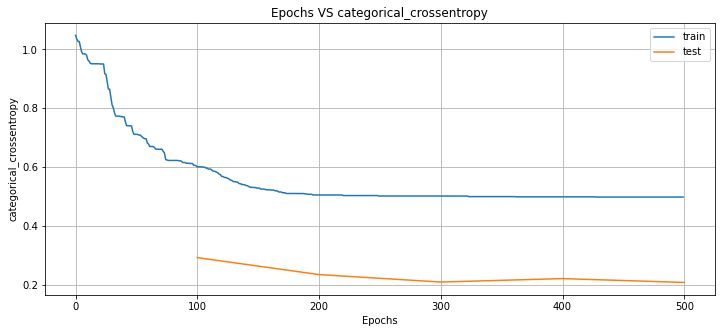

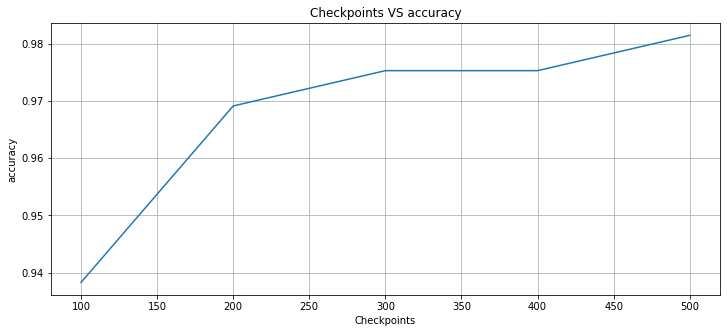

In [11]:
draw_plot(x = [[i for i in range(len(history))], [(i+1)*breakpoint for i in range(len(checkpoints))]], y_list = [history, [ ckp[model.loss_fn] for ckp in checkpoints ]], x_label = 'Epochs', \
    y_label = model.loss_fn, legend=['train', 'test'])
acc = [ ckp['accuracy'] for ckp in checkpoints ]
draw_plot(x = [[(i+1)*breakpoint for i in range(len(checkpoints))]], y_list = [acc], x_label = 'Checkpoints', \
    y_label = 'accuracy')

In [12]:
for checkpoint in checkpoints:
    print(checkpoint, '\n\n')

{'accuracy': 0.9382716049382716, 'mean_square_error': 0.14600193198032757, 'categorical_crossentropy': 0.29194888362178095, 'essential_metrics': {0: {'tp_hit': 78, 'fp_hit': 10, 'tn_hit': 20, 'fn_hit': 0}, 1: {'tp_hit': 12, 'fp_hit': 0, 'tn_hit': 92, 'fn_hit': 4}, 2: {'tp_hit': 8, 'fp_hit': 0, 'tn_hit': 94, 'fn_hit': 6}}, 'checkpoint': 100} 


{'accuracy': 0.9691358024691358, 'mean_square_error': 0.10664875770946072, 'categorical_crossentropy': 0.23432272451895256, 'essential_metrics': {0: {'tp_hit': 78, 'fp_hit': 5, 'tn_hit': 25, 'fn_hit': 0}, 1: {'tp_hit': 15, 'fp_hit': 0, 'tn_hit': 92, 'fn_hit': 1}, 2: {'tp_hit': 10, 'fp_hit': 0, 'tn_hit': 94, 'fn_hit': 4}}, 'checkpoint': 200} 


{'accuracy': 0.9753086419753086, 'mean_square_error': 0.09168860955682538, 'categorical_crossentropy': 0.20894320805867514, 'essential_metrics': {0: {'tp_hit': 78, 'fp_hit': 4, 'tn_hit': 26, 'fn_hit': 0}, 1: {'tp_hit': 15, 'fp_hit': 0, 'tn_hit': 92, 'fn_hit': 1}, 2: {'tp_hit': 11, 'fp_hit': 0, 'tn_hit': 94,

In [13]:
print(model)

Layer 1
Neuron 0: weights:
[-0.9050569   1.8529918   1.6261216  -0.05696147 -0.11148631]
 bias: -1.5498379468917847

Neuron 1: weights:
[-0.00790376 -2.0135102  -0.02250943  0.7391463   2.0284688 ]
 bias: -1.8750377893447876

Neuron 2: weights:
[-0.33180195  0.7175683   0.71978307 -0.02362581  0.12070078]
 bias: 0.000979445525445044

Neuron 3: weights:
[ 0.14076824 -0.01319384 -0.1489565  -0.34330827 -0.180158  ]
 bias: 0.15644699335098267

$
Layer 2
Neuron 0: weights:
[-2.3233933  -3.          0.00963336  1.7559383 ]
 bias: 3.0

Neuron 1: weights:
[ 3.         -0.21306854  2.029453   -0.00705989]
 bias: -0.6443607807159424

Neuron 2: weights:
[-0.00914315  3.         -0.0168302  -0.05266096]
 bias: -0.06509529799222946

$

